In [714]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [715]:
# read the raw data file
df = pd.read_csv("rawdata.csv")
df

,Date,Open,High,Low,Close,Volume,OpenInt,ETFs_index
0,2007-10-30,49.7000,49.7000,49.7000,49.7000,100,0,0
1,2007-10-31,49.6800,50.0000,49.6800,50.0000,4700,0,0
2,2007-11-01,49.3600,49.3600,49.1000,49.1300,19100,0,0
3,2007-11-02,49.2500,49.2500,49.0500,49.0500,4300,0,0
4,2007-11-05,48.9400,48.9400,48.9400,48.9400,100,0,0
...,...,...,...,...,...,...,...,...
185311,2017-11-06,26.1900,26.2300,26.1800,26.1800,5594,0,99
185312,2017-11-07,26.2159,26.2159,26.1757,26.1766,5551,0,99
185313,2017-11-08,26.1700,26.1800,26.1500,26.1701,127275,0,99
185314,2017-11-09,26.1696,26.1900,26.1600,26.1900,229730,0,99


In [716]:
# drop irrelevant feature
df = df.drop("OpenInt", axis=1)

In [717]:
# set the "Date" column as the index
# df.set_index("Date", inplace=True)
df

,Date,Open,High,Low,Close,Volume,ETFs_index
0,2007-10-30,49.7000,49.7000,49.7000,49.7000,100,0
1,2007-10-31,49.6800,50.0000,49.6800,50.0000,4700,0
2,2007-11-01,49.3600,49.3600,49.1000,49.1300,19100,0
3,2007-11-02,49.2500,49.2500,49.0500,49.0500,4300,0
4,2007-11-05,48.9400,48.9400,48.9400,48.9400,100,0
...,...,...,...,...,...,...,...
185311,2017-11-06,26.1900,26.2300,26.1800,26.1800,5594,99
185312,2017-11-07,26.2159,26.2159,26.1757,26.1766,5551,99
185313,2017-11-08,26.1700,26.1800,26.1500,26.1701,127275,99
185314,2017-11-09,26.1696,26.1900,26.1600,26.1900,229730,99


In [718]:
# function to calculate label for each group
def calculate_label(group):
    group["target"] = (group["Close"].shift(-1) > group["Close"]).astype(int)
    group.iloc[-1, group.columns.get_loc("target")] = np.nan
    return group

In [719]:
df_with_labels = df.groupby("ETFs_index").apply(calculate_label)

In [720]:
df_with_labels.reset_index(drop=True, inplace=True)
df_with_labels = df_with_labels.dropna()
df_with_labels

,Date,Open,High,Low,Close,Volume,ETFs_index,target
0,2007-10-30,49.7000,49.7000,49.7000,49.7000,100,0,1.0
1,2007-10-31,49.6800,50.0000,49.6800,50.0000,4700,0,0.0
2,2007-11-01,49.3600,49.3600,49.1000,49.1300,19100,0,0.0
3,2007-11-02,49.2500,49.2500,49.0500,49.0500,4300,0,0.0
4,2007-11-05,48.9400,48.9400,48.9400,48.9400,100,0,1.0
...,...,...,...,...,...,...,...,...
185310,2017-11-03,26.1700,26.2100,26.1700,26.1832,1998,99,0.0
185311,2017-11-06,26.1900,26.2300,26.1800,26.1800,5594,99,0.0
185312,2017-11-07,26.2159,26.2159,26.1757,26.1766,5551,99,0.0
185313,2017-11-08,26.1700,26.1800,26.1500,26.1701,127275,99,1.0


In [721]:
# feature extraction method for each group
def feature_extraction(group):
    time_spans = [2,5,20,60,250]
    for time_span in time_spans:
        rolling_averages = group["Close"].rolling(time_span).mean()
        
        ratio_column = f"Close_Ratio_{time_span}"
        group[ratio_column] = group["Close"] / rolling_averages
        
        trend_column = f"Trend_{time_span}"
        group[trend_column] = group["target"].shift(1).rolling(time_span).sum()
        
    return group
        

In [722]:
# get a list of new feature names
def generate_empty_columns():
    time_spans = [2,5,20,60,250]
    new_predictors = []
    for time_span in time_spans:
        ratio_column = f"Close_Ratio_{time_span}"
        trend_column = f"Trend_{time_span}"
        new_predictors+= [ratio_column, trend_column]
    return new_predictors

In [723]:
# add new features to the datafame
new_features = generate_empty_columns()
for feature in new_features:
    df_with_labels[feature] = -1
df_with_labels

,Date,Open,High,Low,Close,Volume,ETFs_index,target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
0,2007-10-30,49.7000,49.7000,49.7000,49.7000,100,0,1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2007-10-31,49.6800,50.0000,49.6800,50.0000,4700,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2007-11-01,49.3600,49.3600,49.1000,49.1300,19100,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2007-11-02,49.2500,49.2500,49.0500,49.0500,4300,0,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2007-11-05,48.9400,48.9400,48.9400,48.9400,100,0,1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185310,2017-11-03,26.1700,26.2100,26.1700,26.1832,1998,99,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
185311,2017-11-06,26.1900,26.2300,26.1800,26.1800,5594,99,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
185312,2017-11-07,26.2159,26.2159,26.1757,26.1766,5551,99,0.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
185313,2017-11-08,26.1700,26.1800,26.1500,26.1701,127275,99,1.0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [724]:
df_feature_expanded = df_with_labels.groupby('ETFs_index').apply(feature_extraction)

In [725]:
df_feature_expanded

Date     Open     High      Low    Close  Volume  \
ETFs_index                                                                  
0          0       2007-10-30  49.7000  49.7000  49.7000  49.7000     100   
           1       2007-10-31  49.6800  50.0000  49.6800  50.0000    4700   
           2       2007-11-01  49.3600  49.3600  49.1000  49.1300   19100   
           3       2007-11-02  49.2500  49.2500  49.0500  49.0500    4300   
           4       2007-11-05  48.9400  48.9400  48.9400  48.9400     100   
...                       ...      ...      ...      ...      ...     ...   
99         185310  2017-11-03  26.1700  26.2100  26.1700  26.1832    1998   
           185311  2017-11-06  26.1900  26.2300  26.1800  26.1800    5594   
           185312  2017-11-07  26.2159  26.2159  26.1757  26.1766    5551   
           185313  2017-11-08  26.1700  26.1800  26.1500  26.1701  127275   
           185314  2017-11-09  26.1696  26.1900  26.1600  26.1900  229730   

                   ETFs_index  target  Close_Ratio_2  Trend_2  Close_Ratio_5  \
ETFs_index                                                                     
0          0                0     1.0            NaN      NaN            NaN   
           1                0     0.0       1.003009      NaN            NaN   
           2                0     0.0       0.991224      1.0            NaN   
           3                0     0.0       0.999185      0.0            NaN   
           4                0     1.0       0.998877      0.0       0.991411   
...                       ...     ...            ...      ...            ...   
99         185310          99     0.0       0.998917      1.0       0.999340   
           185311          99     0.0       0.999939      0.0       0.999424   
           185312          99     0.0       0.999935      0.0       0.999252   
           185313          99     1.0       0.999876      0.0       0.999241   
           185314          99     0.0       1.000380      1.0       1.000383   

                   Trend_5  Close_Ratio_20  Trend_20  Close_Ratio_60  \
ETFs_index                                                             
0          0           NaN             NaN       NaN             NaN   
           1           NaN             NaN       NaN             NaN   
           2           NaN             NaN       NaN             NaN   
           3           NaN             NaN       NaN             NaN   
           4           NaN             NaN       NaN             NaN   
...                    ...             ...       ...             ...   
99         185310      2.0        0.999083       8.0        0.999860   
           185311      2.0        0.999053       8.0        0.999723   
           185312      2.0        0.999006       8.0        0.999576   
           185313      1.0        0.998834       8.0        0.999296   
           185314      1.0        0.999612       9.0        1.000006   

                   Trend_60  Close_Ratio_250  Trend_250  
ETFs_index                                               
0          0            NaN              NaN        NaN  
           1            NaN              NaN        NaN  
           2            NaN              NaN        NaN  
           3            NaN              NaN        NaN  
           4            NaN              NaN        NaN  
...                     ...              ...        ...  
99         185310      25.0         1.010495      116.0  
           185311      24.0         1.010325      115.0  
           185312      24.0         1.010138      115.0  
           185313      24.0         1.009825      115.0  
           185314      25.0         1.010526      116.0  

[185216 rows x 18 columns]

In [726]:
df_feature_expanded.reset_index(drop=True, inplace=True)
df_feature_expanded = df_feature_expanded.dropna()
df_feature_expanded

,Date,Open,High,Low,Close,Volume,ETFs_index,target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_20,Trend_20,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
250,2008-11-24,25.5900,25.5900,25.1300,25.2100,6219,0,1.0,1.020235,1.0,0.993380,2.0,0.927503,8.0,0.708156,24.0,0.550691,115.0
251,2008-11-25,25.4400,25.4400,25.2500,25.3200,1382,0,1.0,1.002177,2.0,1.005720,2.0,0.938978,9.0,0.717684,24.0,0.554289,115.0
252,2008-11-26,25.4700,25.5500,25.4700,25.5500,1600,0,0.0,1.004521,2.0,1.017361,3.0,0.956427,9.0,0.731330,24.0,0.560481,116.0
253,2008-11-28,24.5500,24.5500,24.5500,24.5500,100,0,0.0,0.980040,1.0,0.983259,3.0,0.927360,9.0,0.709732,24.0,0.539705,116.0
254,2008-12-01,24.1300,24.1300,24.1300,24.1300,230,0,0.0,0.991372,0.0,0.967057,3.0,0.917142,9.0,0.704879,23.0,0.531631,116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185211,2017-11-03,26.1700,26.2100,26.1700,26.1832,1998,99,0.0,0.998917,1.0,0.999340,2.0,0.999083,8.0,0.999860,25.0,1.010495,116.0
185212,2017-11-06,26.1900,26.2300,26.1800,26.1800,5594,99,0.0,0.999939,0.0,0.999424,2.0,0.999053,8.0,0.999723,24.0,1.010325,115.0
185213,2017-11-07,26.2159,26.2159,26.1757,26.1766,5551,99,0.0,0.999935,0.0,0.999252,2.0,0.999006,8.0,0.999576,24.0,1.010138,115.0
185214,2017-11-08,26.1700,26.1800,26.1500,26.1701,127275,99,1.0,0.999876,0.0,0.999241,1.0,0.998834,8.0,0.999296,24.0,1.009825,115.0


In [727]:
df_feature_expanded.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'ETFs_index',
       'target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_20', 'Trend_20', 'Close_Ratio_60', 'Trend_60',
       'Close_Ratio_250', 'Trend_250'],
      dtype='object')

In [728]:
# method to visualize the data distribution (boxplots)
def view_boxplots(group):
    cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'ETFs_index',
       'target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_20', 'Trend_20', 'Close_Ratio_60', 'Trend_60',
       'Close_Ratio_250', 'Trend_250']
    box_plots = group[cols].boxplot(vert = False)
    plt.show()
    

In [729]:
# generate boxplots for all groups
# df_feature_expanded.groupby("ETFs_index").apply(view_boxplots)

# for name, group in grouped:
#     view_boxplots(group)

In [730]:
# # method to detect and remove outliers
# def remove_outliers(group):
#     cols = ['Volume', 'ETFs_index']
#     z_scores = stats.zscore(group[cols])
#     abs_z_scores = abs(z_scores)
#     filtered_entries = (abs_z_scores < 3).all(axis=1)
#     return group[filtered_entries]

In [731]:
# # detect and remove outliers by group
# # df_removed_outliers = df_feature_expanded.groupby("ETFs_index").apply(remove_outliers)
# df_filtered = pd.DataFrame()

# # Iterate over groups and filter outliers
# for name, group in df.groupby("ETFs_index"):
#     filtered_group = remove_outliers(group)
#     df_filtered = pd.concat([df_filtered, filtered_group], ignore_index=True)


              Date     Open     High      Low    Close  Volume  ETFs_index  \
250     2008-11-24  25.5900  25.5900  25.1300  25.2100    6219           0   
251     2008-11-25  25.4400  25.4400  25.2500  25.3200    1382           0   
252     2008-11-26  25.4700  25.5500  25.4700  25.5500    1600           0   
253     2008-11-28  24.5500  24.5500  24.5500  24.5500     100           0   
254     2008-12-01  24.1300  24.1300  24.1300  24.1300     230           0   
...            ...      ...      ...      ...      ...     ...         ...   
185211  2017-11-03  26.1700  26.2100  26.1700  26.1832    1998          99   
185212  2017-11-06  26.1900  26.2300  26.1800  26.1800    5594          99   
185213  2017-11-07  26.2159  26.2159  26.1757  26.1766    5551          99   
185214  2017-11-08  26.1700  26.1800  26.1500  26.1701  127275          99   
185215  2017-11-09  26.1696  26.1900  26.1600  26.1900  229730          99   

        target  Close_Ratio_2  Trend_2  Close_Ratio_5  Trend_5 

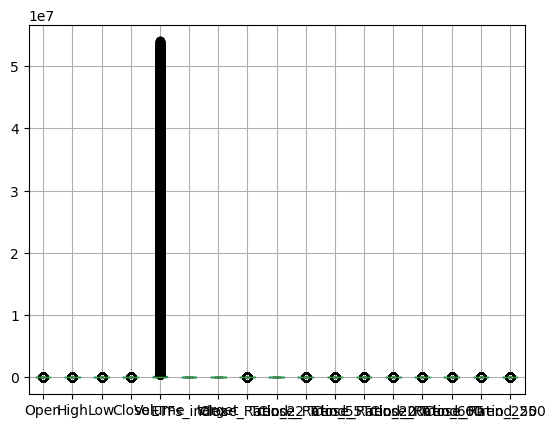

In [732]:
# cols = ['Volume', 'ETFs_index']

# print(df.describe())

# detect outliers
z_scores = stats.zscore(df_feature_expanded['Volume'])
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df_feature_expanded = df_feature_expanded[filtered_entries]

print(df_feature_expanded)

box_plots = df_feature_expanded.boxplot()
plt.show()

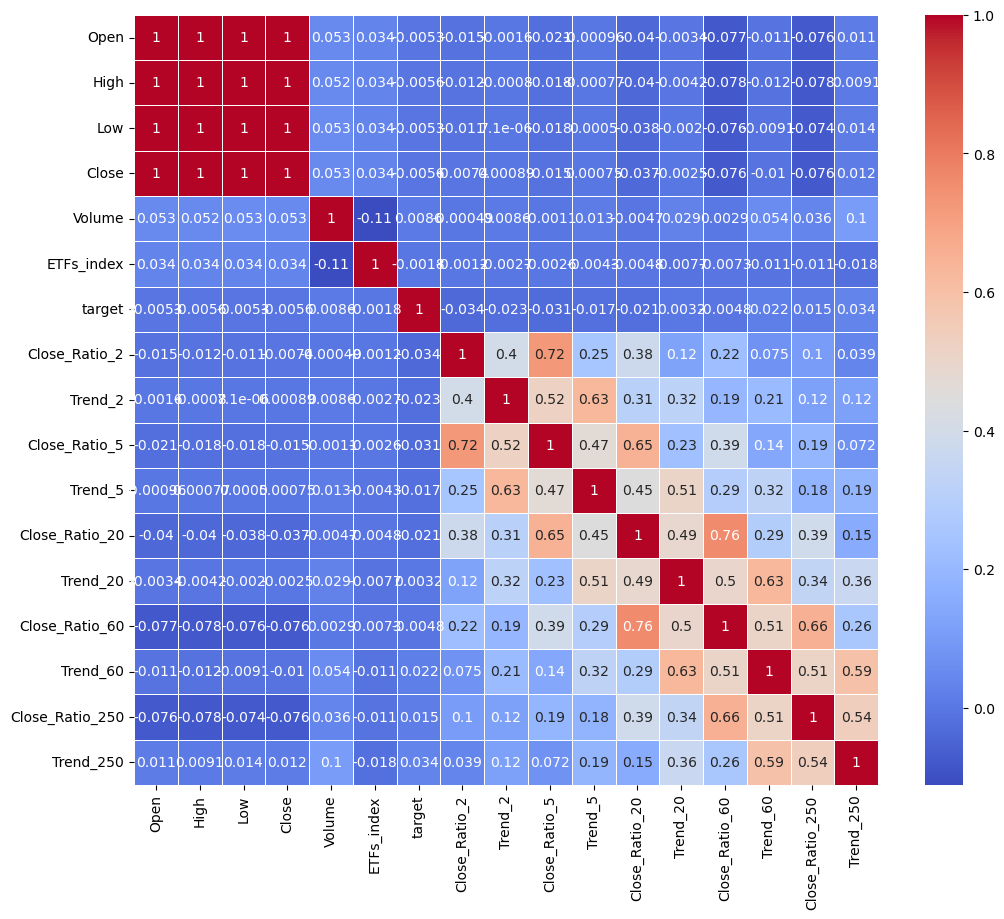

In [733]:
# feature selection, plot heatmap for all features and labels
cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'ETFs_index',
       'target', 'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_20', 'Trend_20', 'Close_Ratio_60', 'Trend_60',
       'Close_Ratio_250', 'Trend_250']
corr_matrix = df_feature_expanded[cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

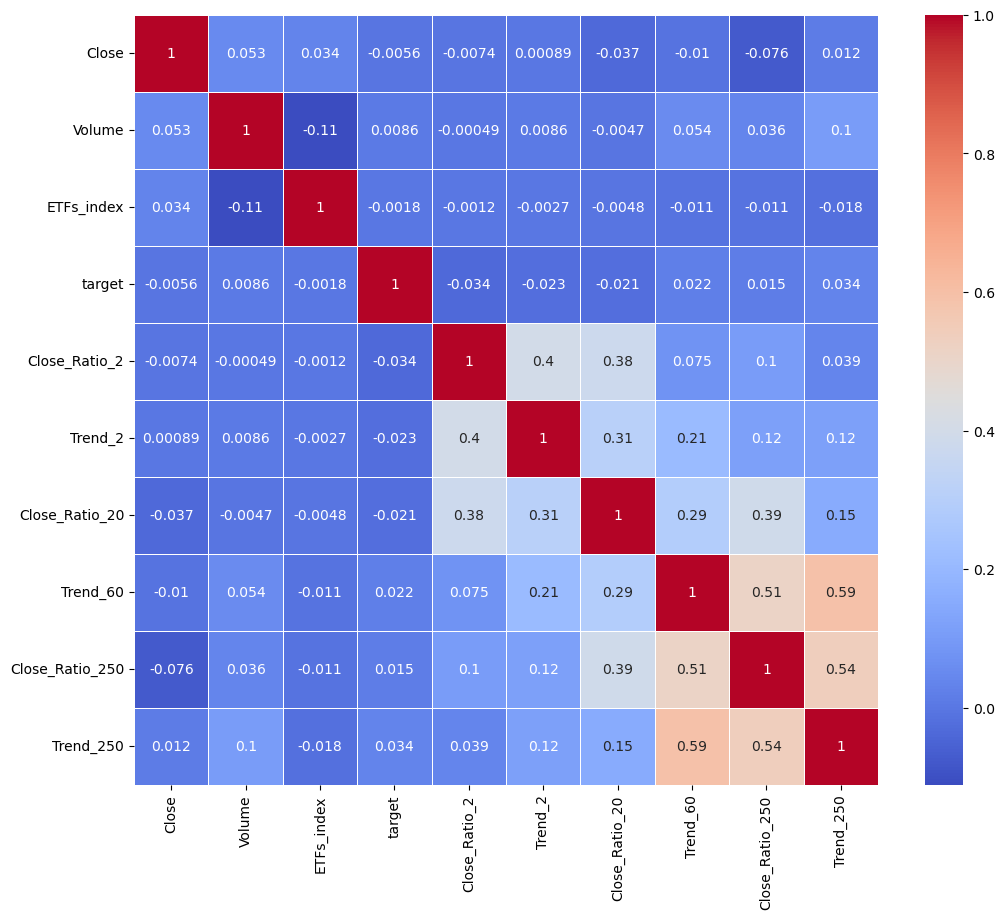

In [734]:
selected_features = ['Close', 'Volume', 'ETFs_index',
       'target', 'Close_Ratio_2', 'Trend_2',
       'Close_Ratio_20', 'Trend_60',
       'Close_Ratio_250', 'Trend_250']
partial_corr_matrix = df_feature_expanded[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(partial_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

In [735]:
df_feature_expanded = df_feature_expanded.dropna()
df_export = df_feature_expanded.reset_index(drop=True)
print(df_export)

              Date     Open     High      Low    Close  Volume  ETFs_index  \
0       2008-11-24  25.5900  25.5900  25.1300  25.2100    6219           0   
1       2008-11-25  25.4400  25.4400  25.2500  25.3200    1382           0   
2       2008-11-26  25.4700  25.5500  25.4700  25.5500    1600           0   
3       2008-11-28  24.5500  24.5500  24.5500  24.5500     100           0   
4       2008-12-01  24.1300  24.1300  24.1300  24.1300     230           0   
...            ...      ...      ...      ...      ...     ...         ...   
157998  2017-11-03  26.1700  26.2100  26.1700  26.1832    1998          99   
157999  2017-11-06  26.1900  26.2300  26.1800  26.1800    5594          99   
158000  2017-11-07  26.2159  26.2159  26.1757  26.1766    5551          99   
158001  2017-11-08  26.1700  26.1800  26.1500  26.1701  127275          99   
158002  2017-11-09  26.1696  26.1900  26.1600  26.1900  229730          99   

        target  Close_Ratio_2  Trend_2  Close_Ratio_5  Trend_5 

In [736]:
# methods to split data by 7:3
def train_test_split(group):
    total_rows = len(group)
    first_70_percent = int(0.7 * total_rows)
    
    first_70_indices = group.index[:first_70_percent].tolist()
    remaining_indices = group.index[first_70_percent:].tolist()
    
    return first_70_indices, remaining_indices

In [737]:
# train test split
selected_indices = df_export.groupby("ETFs_index").apply(train_test_split)

first_70_percent_indices = []
remaining_indices = []

for indices in selected_indices:
    first_70_percent_indices.extend(indices[0])
    remaining_indices.extend(indices[1])
    
# print(remaining_indices)
    
features = ['Close', 'Volume',
       'Close_Ratio_2', 'Trend_2',
       'Close_Ratio_20', 'Trend_60',
       'Close_Ratio_250', 'Trend_250']
    
xTrain = df_export.loc[first_70_percent_indices, features]
yTrain = df_export.loc[first_70_percent_indices, "target"]

xTest = df_export.loc[remaining_indices, features]
yTest = df_export.loc[remaining_indices, "target"]


# normalize
numerical_cols = ['Close', 'Volume',
       'Close_Ratio_2', 'Trend_2',
       'Close_Ratio_20', 'Trend_60',
       'Close_Ratio_250', 'Trend_250']

scalar1 = StandardScaler()
xTrain[numerical_cols] = scalar1.fit_transform(xTrain[numerical_cols])
xTest[numerical_cols] = scalar1.transform(xTest[numerical_cols])

# scaler2 = MinMaxScaler()
# xTrain['ETFs_index'] = scaler2.fit_transform(xTrain['ETFs_index'].values.reshape(-1, 1))
# xTest['ETFs_index'] = scaler2.transform(xTest['ETFs_index'].values.reshape(-1, 1))

xTrain.to_csv('xTrain.csv', index=False)
yTrain.to_csv('yTrain.csv', index=False)

xTest.to_csv('xTest.csv', index=False)
yTest.to_csv('yTest.csv', index=False)


In [738]:
print(xTest)

           Close    Volume  Close_Ratio_2   Trend_2  Close_Ratio_20  Trend_60  \
1449   -0.196923 -0.239453      -0.444972 -1.476415       -0.974583 -1.958921   
1450   -0.199283 -0.239472      -0.428361 -1.476415       -1.058574 -1.958921   
1451   -0.195687 -0.239178       0.638834 -0.039700       -0.697207 -1.958921   
1452   -0.196024 -0.239471      -0.065015 -0.039700       -0.652802 -1.958921   
1453   -0.200856 -0.239062      -0.872877 -1.476415       -0.938029 -1.958921   
...          ...       ...            ...       ...             ...       ...   
157998 -0.203293 -0.239127      -0.121390 -0.039700       -0.051026 -1.456597   
157999 -0.203329 -0.238352      -0.011549 -1.476415       -0.051772 -1.707759   
158000 -0.203367 -0.238361      -0.011960 -1.476415       -0.052916 -1.707759   
158001 -0.203440 -0.212101      -0.018324 -1.476415       -0.057103 -1.707759   
158002 -0.203216 -0.189999       0.035849 -0.039700       -0.038151 -1.456597   

        Close_Ratio_250  Tr